In [27]:
import numpy as np
import  matplotlib.pyplot as plt
import scipy.special as sp

In [28]:
def source(no_of_users, no_of_bits):
    # Generate a random binary matrix with shape (no_of_users, no_of_bits)
    # Each element is either 0 or 1
    return np.random.randint(0, 2, (no_of_users, no_of_bits))

no_of_users = 2  # Define the number of users
no_of_bits = 8000  # Define the number of bits per user

# Generate the message bits as a binary matrix
msg_bits1 = source(no_of_users, no_of_bits)  # Generating bit stream of size (no_of_users, no_of_bits)
# Print the generated message bits
print("msg\n", msg_bits1)  # Each row represents the bit stream for one user


msg
 [[1 1 1 ... 0 1 1]
 [1 1 0 ... 1 0 1]]


In [29]:
def mod(bits):
    # Map binary values: 0 to -1 and 1 to 1
    return 2 * bits - 1

# Apply modulation to the message bits
symbols = mod(msg_bits1)
# Print the modulated symbols
print(symbols)


[[ 1  1  1 ... -1  1  1]
 [ 1  1 -1 ...  1 -1  1]]


In [30]:
def awgn(symbols, snr_db):
    # Sum the columns of the symbols array to combine signals from different users
    combined_symbols = np.sum(symbols, axis=0)  # This corresponds to y = ∑x_i + n
    
    # Print combined symbols for debugging (commented out)
    # print(combined_symbols)   
    
    # Calculate the average power of the combined signal
    signal_power = np.mean(np.abs(combined_symbols)**2)  # Signal power calculation

    # Convert SNR from dB to linear scale
    snr_linear = 10**(snr_db / 10.0)
    
    # Calculate noise variance based on the signal power and SNR
    noise_variance = signal_power / (2 * snr_linear)

    # Generate complex Gaussian noise with the calculated variance
    noise = np.sqrt(noise_variance) * np.random.randn(len(combined_symbols))  # Generating noise with accordance with signal power

    # Add the noise to the combined symbols and return the result
    return combined_symbols + noise

# Define the SNR in dB (array with one value in this case)
snr_db = np.arange(0, 1, 1)

# Pass the modulated symbols through the AWGN channel
received_signal = awgn(symbols, snr_db)

# Print the received signal after adding noise
print(received_signal)


[ 0.86541343  3.02580975 -0.22112116 ... -0.52792803  1.79040427
  0.81367171]


In [31]:
def demod(received_signal):
    # Define the possible symbols for decoding
    symbols = [-2, 0, 2]  # The symbols that the noisy received signals will be decoded into

    # Initialize an empty list to store the demodulated symbols
    demodulated_symbols = []
    
    # Iterate over each received signal to decode it
    for i in received_signal:
        # Find the closest symbol to the received signal based on minimum distance
        closest_symbol = min(symbols, key=lambda s: np.abs(i - s))  # Decoding by finding the minimum distance
        demodulated_symbols.append(closest_symbol)  # Append the closest symbol to the list

    # Convert the list of demodulated symbols to a numpy array and return it
    return np.array(demodulated_symbols)

# Perform demodulation on the received signal
demod_symbols = demod(received_signal)

# Print the demodulated symbols
print(demod_symbols)


[0 2 0 ... 0 2 0]


In [32]:
def calculate_ber(msg, rec, no_of_users, no_of_bits):
    # Modulate the original message bits to get the transmitted symbols
    sym1 = mod(msg)
    
    # Sum the transmitted symbols across all users
    combined_symbols = np.sum(sym1, axis=0)  # This is used to compare with the received symbols
    
    # Print statements for debugging (currently commented out)
    # print(msg)
    # msg_sum = np.sum(msg, axis=0)
    # print("\n", msg_sum)
    # print("\n", rec)

    # Calculate the Bit Error Rate (BER) by comparing the combined transmitted symbols with the received symbols
    ber = np.mean(combined_symbols != rec)  # BER is calculated by averaging the number of symbol errors
    
    return ber

# Calculate the Bit Error Rate (BER) using the original message bits and the demodulated symbols
BER = calculate_ber(msg_bits1, demod_symbols, no_of_users, no_of_bits)

# Print the calculated BER
print(BER)


0.238125


In [33]:
# Function to simulate the system for different SNR values
def simulate(snr_db_range, msg_bits, no_of_users, no_of_bits):
    ber = []  # Initialize an empty list to store Symbol Error Rate (SER) for each SNR value

    # Iterate over the range of SNR values
    for snr_db in snr_db_range:
        # Print the current SNR value for debugging (commented out)
        # print("snr=", snr_db)
        
        # Modulate the message bits to obtain transmitted symbols
        transmitted_symbols = mod(msg_bits)  # Modulation: bit stream --> symbols
        
        # Pass the transmitted symbols through the AWGN channel to get received symbols
        received_symbols = awgn(transmitted_symbols, snr_db)  # Received symbols: channel output = symbols + noise
        
        # Demodulate the received symbols to recover the transmitted symbols
        demodulated_symbols = demod(received_symbols)  # Demodulation: noisy_symbols --> decoded symbols
        
        # Calculate the Symbol Error Rate (SER) and append it to the list
        ber.append(calculate_ber(msg_bits, demodulated_symbols, no_of_users, no_of_bits))  # Calculate SER
    
        # Print BER for the current SNR value for debugging (commented out)
        # print(ber)
        # print("\n\n")

    return ber  # Return the list of SER values for the given range of SNR values

# Define the range of SNR values (in dB) for the simulation
snr_db_range = np.arange(0, 12, 1)  # Input for SNR range to plot

# Run the simulation to obtain SER for each SNR value
ber_bpsk_sum = simulate(snr_db_range, msg_bits1, no_of_users, no_of_bits)

# Print the Bit Error Rate (BER) for each SNR value
print(ber_bpsk_sum)


[0.242, 0.191, 0.1595, 0.11675, 0.08425, 0.05525, 0.034875, 0.02075, 0.01, 0.00325, 0.001375, 0.0005]


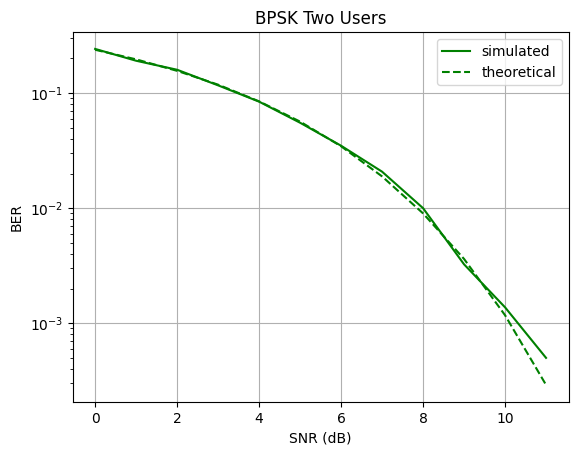

In [34]:
# Convert SNR values from dB to linear scale
snr_lin = 10**(snr_db_range / 10)  # SNR in linear scale

# Calculate the theoretical Bit Error Rate (BER) for BPSK with two users
ser_bpsk_sum_theory = 0.75 * sp.erfc(np.sqrt(snr_lin / 2))  # Theoretical SER formula for two users BPSK

# Plot the simulated BER values
plt.semilogy(snr_db_range, ber_bpsk_sum, linestyle='-', color="g", label='simulated')

# Plot the theoretical BER values
plt.semilogy(snr_db_range, ser_bpsk_sum_theory, linestyle='--', color='g', label='theoretical')

plt.xlabel("SNR (dB)")  
plt.ylabel("BER")       
plt.legend()         
plt.title("BPSK Two Users") 
plt.grid(True)
plt.show()
